# Analysis on user timelines
To see how these user-timelines were downloaded, see:

`sm_w2v.__main__.run_user_timeline_download()`

Data were downloaded to:

`data/user_timeline_tweets.json`

In [1]:
# load and concatenate tweet timeline-documents
import json

train = True

user_timelines = dict()
with open('../data/user_timeline_tweets.json') as f_in:
    for l in f_in:
        try:
            twt = json.loads(l)
        except:
            continue
        user_id_str = twt['user']['id_str']
        if user_id_str in user_timelines:
            user_timelines[user_id_str] = user_timelines[user_id_str] + ' ' + twt['text']
        else:
            user_timelines[user_id_str] = twt['text']

# clean/preprocess text

In [2]:
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
import re


STOPWORDS = set(['rt', '', 'httpst', 'amp', 'https\'', 'ang',
                'ng', 'tcot', 'ako', , 'sa', 'ko', 'rp', 'roc',
                'fe', 'sk', 'holi', 'asa', 'guru', 'yah', 'lista',
                 'hah' 'il', 'seo', 'casa', 'qotd', 'noh']).union(set(STOPWORDS)) \
    .union(set(stopwords.words('spanish'))) \
    .union(set(stopwords.words('portuguese'))) \
    .union(set(stopwords.words('german'))) \
    .union(set(stopwords.words('dutch')))

def clean_text(text):
    clean = re.sub(r'http.*$', '', text)
    clean = re.sub(r'[^a-zA-Z\s]', '', clean)

    clean = clean.lower()
    word_list = clean.split()
    word_list = [w for w in word_list if (w not in STOPWORDS)]

    return word_list

user_clean_timelines = dict()
for user_id_str in user_timelines.keys():
    user_clean_timelines[user_id_str] = clean_text(user_timelines[user_id_str])

# LDA topic modeling on timeline documents

In [12]:
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel
from gensim import corpora


user_timelines_keys = []
texts = []
for k, v in user_clean_timelines.items():
    user_timelines_keys.append(k)
    texts.append(v)

# filter out users with less than 200 words in the tweets in their timelines
long_timelines = [t for t in texts if len(t) > 200]
dictionary = corpora.Dictionary(long_timelines)
dictionary.filter_extremes(no_below=10, no_above=0.3, keep_n=100000)
corpus = [dictionary.doc2bow(text) for text in long_timelines]
tfidf = TfidfModel(corpus)
corpus = tfidf[corpus]
corpus = corpus[0:500]
print('number of user-timelines:', len(corpus))

if train:
    model = LdaModel(corpus, id2word=dictionary, num_topics=10, iterations=50, passes=10)
    model.save('../models/lda_user_timelines.model')

else:
    model = LdaModel.load('../models/lda_user_timelines.model')

number of user-timelines: 297


In [23]:
# idenitify topics of interest
pd.DataFrame([row[1].split(' + ') for row in model.print_topics(20)]).iloc[:,0:10]

,0,1,2,3,4,5,6,7,8,9
0,0.001*hivaids,0.001*condoms,0.001*bitcoin,0.001*stigma,0.001*cdcstd,0.001*kanyewest,0.001*nyhaad,0.001*entrepreneur,0.001*realestate,0.001*blacklivesmatter
1,0.002*ang,0.002*ng,0.002*tcot,0.001*ako,0.001*sa,0.001*ko,0.001*pjnet,0.001*realdonaldtrump,0.001*gopdebate,0.001*cruzcrew
2,0.001*fertility,0.001*infertility,0.001*meme,0.001*mxico,0.001*rp,0.001*deactivate,0.001*rail,0.001*roc,0.000*offensive,0.000*feedly
3,0.001*colombia,0.000*pozlivingbc,0.000*fe,0.000*repostapp,0.000*sprite,0.000*bccfe,0.000*thewalkingdead,0.000*npinchat,0.000*interior,0.000*wellness
4,0.001*businessinsider,0.001*stacks,0.000*noh,0.000*teaparty,0.000*sk,0.000*holi,0.000*alzheimers,0.000*caregiver,0.000*asa,0.000*guru
5,0.001*armenia,0.001*wordpress,0.001*georgia,0.001*topping,0.001*lgbtqia,0.000*yah,0.000*faction,0.000*checkout,0.000*narendramodi,0.000*examination
6,0.001*knitting,0.001*lista,0.001*naral,0.000*gust,0.000*worldbank,0.000*bigdata,0.000*haiku,0.000*vdeo,0.000*mhealth,0.000*hah
7,0.001*nigga,0.001*niggas,0.001*bernie,0.001*lmao,0.001*nhsengland,0.001*bitches,0.001*bae,0.001*uniteblue,0.001*il,0.001*gop
8,0.002*socialmedia,0.001*seo,0.001*socialmediamarketing,0.001*der,0.001*und,0.001*entrepreneur,0.001*ist,0.001*nowplaying,0.001*foxbusiness,0.001*enews
9,0.001*collage,0.001*mileycyrus,0.000*undetectable,0.000*ddlovato,0.000*casa,0.000*cnet,0.000*qotd,0.000*vacations,0.000*nashville,0.000*heros


In [5]:
# show users vs. features (topics)
features = dict()

for i, doc in enumerate(corpus):
    features[user_timelines_keys[i]] = model.get_document_topics(doc, minimum_probability=None)


In [6]:
# do time-plot of features for a specific user (topics) vs. time
import pandas as pd
import numpy as np

columns = ['topic0', 'topic1', 'topic2', 'topic3', 'topic4',
           'topic5', 'topic6', 'topic7', 'topic8', 'topic9']
index = user_timelines_keys
df = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns=columns, index=index)

for doc_ind, user_doc in enumerate(features.values()):
    for topic in user_doc:
        df.iloc[doc_ind, topic[0]] = topic[1]

In [7]:
df.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
1092041790,0.000000,0.340461,0.000000,0.000000,0.038214,0.579821,0.000000,0.000000,0.000000,0.000000
369263530,0.000000,0.000000,0.000000,0.000000,0.000000,0.950505,0.000000,0.000000,0.000000,0.000000
703532351238840324,0.000000,0.093992,0.000000,0.000000,0.063378,0.788377,0.000000,0.000000,0.000000,0.000000
239712031,0.000000,0.103955,0.000000,0.000000,0.000000,0.707124,0.128868,0.000000,0.000000,0.000000
3364965988,0.012719,0.141618,0.012719,0.012719,0.063107,0.706236,0.012726,0.012719,0.012719,0.012719


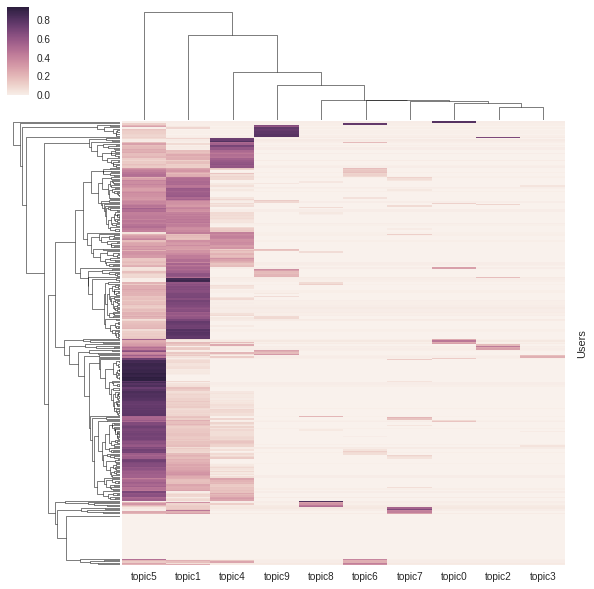

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df.index.name = 'Users'
figure = sns.clustermap(df, yticklabels="")

figure.savefig('user_timeline_clustermap.pdf', format='pdf')